In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
from IPython.display import Audio
%matplotlib inline

In [3]:
outputs = h5py.File("/work/asr3/rossenbach/rilling/sisyphus_work_dirs/glow_tts_asr_v2/i6_core/returnn/forward/ReturnnForwardJob.jsQFljAB7xU4/output/output.hdf", "r")
outputs.keys()

<KeysViewHDF5 ['inputs', 'labels', 'seqLengths', 'seqTags']>

In [4]:
spectograms = np.array(outputs["inputs"])
lengths = np.array(outputs["seqLengths"])[:, 0]
spectograms.shape, lengths[0]

((411248, 80), 370)

In [5]:
np.max(lengths)

1066

In [6]:
def get_spec_for_index(specs, lengths, index):
    start = 0
    end = 0
    for i in range(index+1):
        start = end
        end += lengths[i]
    return specs[start:end].T

In [17]:
index = 35
spec = get_spec_for_index(spectograms, lengths, index)

In [18]:
gt_specs = torch.load("/u/lukas.rilling/experiments/glow_tts_asr/audio_features_first_batch.pt").detach().cpu().numpy()

gt_spec = gt_specs[index]
gt_spec[index]


array([ 7.97200322e-01,  4.34075475e-01, -9.82473066e-05, -4.85509560e-02,
       -1.61843672e-01, -2.46800184e-01, -3.27860147e-01, -1.55847877e-01,
       -3.79106462e-01, -4.09549564e-01, -6.20703042e-01, -8.01720977e-01,
       -8.56635749e-01, -1.13246906e+00, -1.11216223e+00, -9.39653993e-01,
       -5.19755363e-01, -2.76357323e-01, -1.36098683e-01, -2.37681702e-01,
       -4.87939298e-01, -2.55065300e-02,  3.35707098e-01,  4.58497196e-01,
        7.25643992e-01,  6.70303226e-01,  9.21456158e-01,  8.74787092e-01,
        8.54754865e-01,  1.03931022e+00,  1.04314089e+00,  7.31797993e-01,
        2.09846616e-01, -4.99135815e-02, -2.61488408e-01, -2.58583695e-01,
       -9.45943817e-02, -2.11083338e-01, -6.75555110e-01, -4.30073142e-01,
        6.64946623e-03, -5.89510985e-02, -5.21695673e-01, -7.37150490e-01,
       -4.65776384e-01, -1.10698543e-01,  1.10459113e+00,  1.82098746e+00,
        2.10503411e+00,  2.14149666e+00,  1.99382877e+00,  1.77977538e+00,
        1.89874792e+00,  

In [19]:
def plot_spec(spec):
    fig, ax = plt.subplots()
    shape = spec.shape
    x = np.arange(0, shape[0]+1)
    y = np.arange(0, shape[1]+1)

    ax.pcolormesh(spec[:, :shape[1]])
    plt.show()


In [20]:
gt_spec.shape, spec.shape

((80, 411), (80, 306))

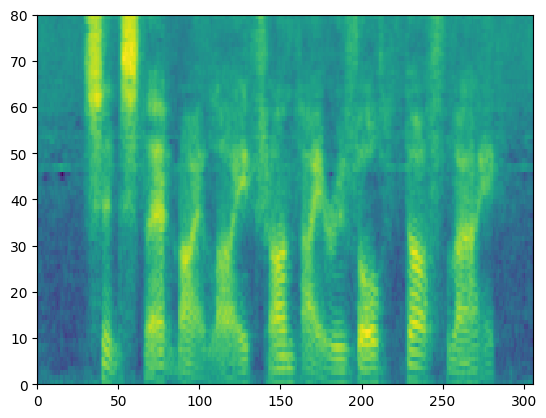

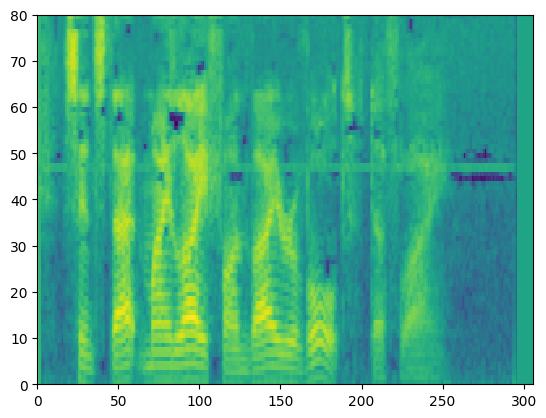

In [21]:
plot_spec(spec)
plot_spec(gt_spec[:, :spec.shape[1]])

In [22]:
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=None, ylim=None):
#   waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [23]:
def inv_preemphasis(wav, preemphasis):
        """
        :param np.array wav:
        :param float k:
        :return:
        """
        from scipy import signal
        return signal.lfilter([1], [1, -preemphasis], wav)

In [24]:
def get_waveform_of_spec(spec):
    norm_std_dev = 30.906690797087478
    norm_mean = -76.49818038940428

    # s = spec.detach().cpu().numpy()
    s = spec.copy()
    print(np.min(s), np.max(s))
    s *= norm_std_dev
    s += norm_mean
    s /= 20
    s = np.power(10,s)
    print(np.min(s), np.max(s))
    num_freq = 1024
    iverse_mel = torchaudio.transforms.InverseMelScale(num_freq // 2 + 1, 80, f_min=60, f_max=7600, sample_rate=16000)
    spec_tensor = torch.Tensor(s)
    power_spec = iverse_mel(spec_tensor)
    
    power_spec[:5,:] = 0
    power_spec[-55:,:] = 0
    plot_spec(power_spec)
    print(torch.sum(power_spec, 1))
    print(f"spec.shape: {spec.shape}")
    print(f"power_spec.shape: {power_spec.shape}")
    griffin_lim = torchaudio.transforms.GriffinLim(num_freq, n_iter=60, win_length=int(0.05*16000), hop_length=int(0.0125*16000))

    wave = griffin_lim(power_spec)
    wave = wave.unsqueeze(0)
    wave = inv_preemphasis(wave, 0.97)
    plot_waveform(wave)
    return Audio(wave, rate=16000)


-2.6836245 1.9856254
1.0665806e-08 0.17520507


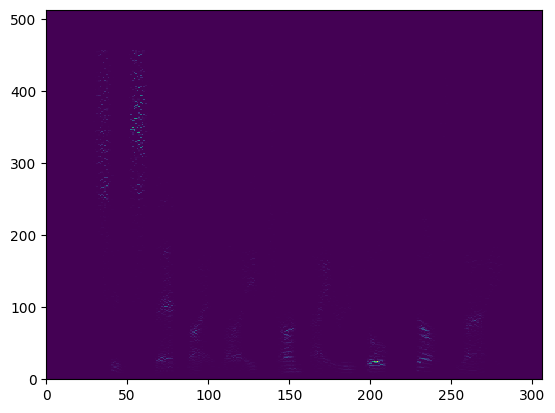

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.1954e-03,
        2.2680e-03, 4.5730e-02, 6.6894e-02, 1.1286e-01, 1.8741e-01, 1.5326e-01,
        1.3722e-01, 2.1049e-01, 2.1343e-01, 1.8931e-01, 2.3004e-01, 2.4206e-01,
        4.7672e-01, 4.5189e-01, 3.4995e-01, 4.1446e-01, 3.7207e-01, 5.1773e-01,
        1.1526e+00, 7.1953e-01, 4.5696e-01, 5.0414e-01, 5.8672e-01, 5.1732e-01,
        4.5599e-01, 4.6516e-01, 2.3920e-01, 2.3676e-01, 2.8524e-01, 3.2853e-01,
        4.5602e-01, 1.7583e-01, 2.4211e-01, 1.0416e-01, 1.0740e-01, 9.8829e-02,
        1.0456e-01, 1.7984e-01, 1.5980e-01, 7.4121e-02, 9.1700e-02, 1.2676e-01,
        1.1805e-01, 8.3981e-02, 7.0719e-02, 1.9328e-01, 1.0509e-01, 9.3955e-02,
        1.2218e-01, 1.2516e-01, 1.1478e-01, 2.3546e-01, 8.5106e-02, 1.7429e-01,
        2.7890e-01, 5.8021e-02, 2.3169e-01, 1.6560e-01, 1.9345e-01, 1.4628e-01,
        2.1487e-01, 3.5251e-01, 1.9148e-01, 3.7647e-01, 3.4219e-01, 1.4320e-01,
        1.7247e-01, 1.4966e-01, 1.7542e-

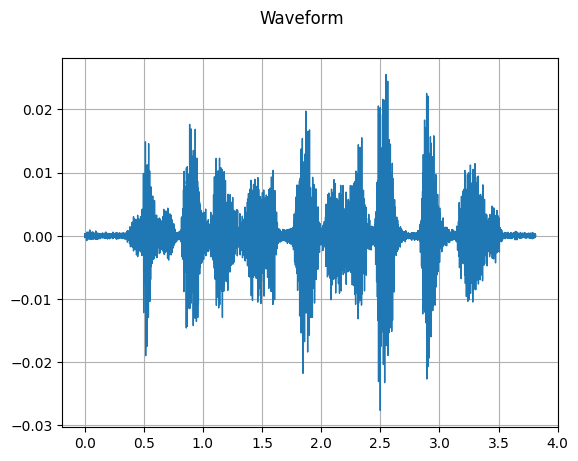

In [25]:
get_waveform_of_spec(spec)


-3.9793942 2.8526406
1.06070756e-10 3.8315558


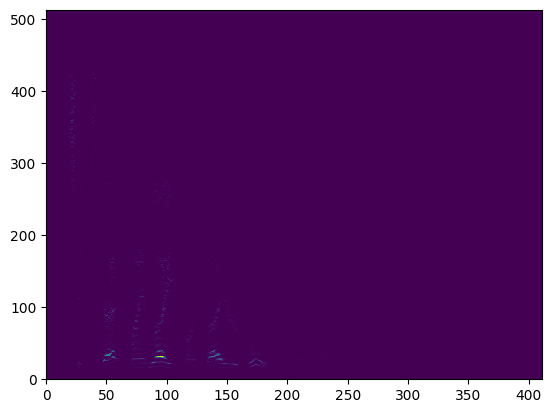

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7546e-02,
        1.0675e-02, 2.0585e-01, 1.1244e-01, 2.6764e-01, 7.9825e-01, 1.2324e+00,
        4.8817e-01, 4.0250e-01, 4.2347e-01, 1.2334e+00, 2.3589e+00, 1.8744e+00,
        8.9585e-01, 1.7405e+00, 3.7212e+00, 7.2472e+00, 5.4283e+00, 6.9784e+00,
        4.3310e+00, 3.1714e+00, 5.2365e+00, 8.4366e+00, 8.8647e+00, 1.2537e+01,
        1.2919e+01, 2.1852e+01, 1.0260e+01, 1.0145e+01, 7.7176e+00, 6.0620e+00,
        6.0960e+00, 3.4598e+00, 6.5137e+00, 4.8170e+00, 3.0691e+00, 1.8304e+00,
        9.8489e-01, 1.9231e+00, 7.0415e-01, 1.2001e+00, 1.0865e+00, 1.8768e+00,
        1.1093e+00, 8.1262e-01, 6.0949e-01, 1.0089e+00, 4.9537e-01, 4.3917e-01,
        6.6706e-01, 6.4423e-01, 5.8556e-01, 9.3380e-01, 5.0271e-01, 6.7989e-01,
        8.8490e-01, 6.1698e-01, 6.2925e-01, 4.3481e-01, 1.0212e+00, 7.4811e-01,
        1.1499e+00, 9.9677e-01, 1.0353e+00, 8.3736e-01, 1.6100e+00, 8.9853e-01,
        8.5326e-01, 1.2660e+00, 6.8597e-

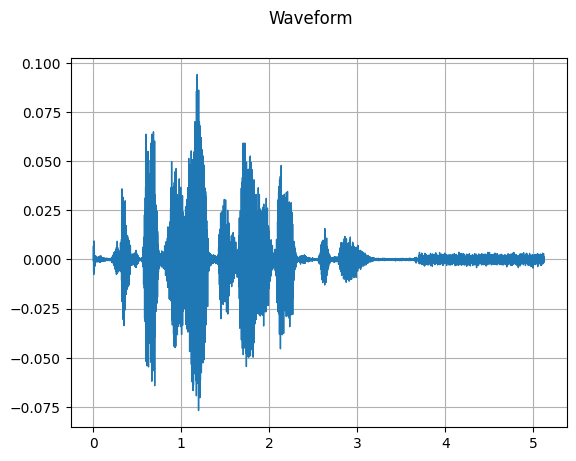

In [26]:
get_waveform_of_spec(gt_spec)